In [1]:
import json
from datetime import datetime, timedelta
import pathlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.metrics import mutual_info_score

In [2]:
# load traces
relativePathToData = 'data/sequential_data'

pathToData = pathlib.Path().absolute().parent / relativePathToData
pathToTraces = pathToData / 'traces'

def loadJson(link):
    with open(link) as f:
        data = json.load(f)
    return data

operations = sorted(list(map(lambda x: x.name, list(pathToTraces.glob('**'))[1:])))

traces = {}
for operation in operations:
    pathToOperation = pathToTraces / operation
    pathes = list(pathToOperation.glob('*.json'))
    traces[operation] = {}
    traces[operation]['id'] = list(map(lambda x: x.name[:x.name.find('.json')], pathes))
    traces[operation]['data'] = list(map(lambda x: loadJson(x), pathes))

In [4]:
# load metrics
pathToMetrics = pathToData / 'fixed_metrics'
nodeNames = sorted(list(map(lambda x: x.name[:x.name.find('_')], list(pathToMetrics.glob('*.csv')))))

nodes = {}
for name in nodeNames:
    nodes[name] = {}
    nodes[name]['data'] = pd.read_csv(pathToMetrics / (name + '_metrics.csv'))

for name in nodeNames:
    nodes[name]['data']['now'] = nodes[name]['data']['now'].map(
        lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S CEST'))

metrics = list(nodes[nodeNames[0]]['data'].keys())
metrics.remove('now')
metrics.remove('load.cpucore')  # always == 8
metrics = sorted(metrics)

In [5]:
# parse of json data to graph
def parseTrace(operation, df, graph):
    G = graph
    for item in df['children']:
        trace = {}
        trace['operation'] = operation
        trace['host'] = item.get('info').get('host') 
        trace['name'] = item.get('info').get('name')
        trace['service'] = item.get('info').get('service')
        trace['project'] = item.get('info').get('project') 
        trace['startTimestamp'] = datetime.strptime(item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-start').get('timestamp'), '%Y-%m-%dT%H:%M:%S.%f')
        endTimestamp = item.get('info').get('meta.raw_payload.' + item.get('info').get('name') + '-stop', {'timestamp': 'Null'}).get('timestamp') 
        if endTimestamp != 'Null':
            trace['endTimestamp'] = datetime.strptime(endTimestamp, '%Y-%m-%dT%H:%M:%S.%f')
            trace['duration'] = trace['endTimestamp'] - trace['startTimestamp']
        else: 
            trace['endTimestamp'] = 'Null'
            trace['duration'] = 'Null'
        trace['trace_id'] = item.get('trace_id') 
        trace['parent_id'] = item.get('parent_id') 
        trace['base_id'] = item.get('info').get('meta.raw_payload.' + item['info']['name'] + '-start').get('base_id')
        trace['isRoot'] = trace['parent_id'] == trace['base_id']
        
        G.add_nodes_from([(trace['trace_id'], trace)])
        if not(trace['isRoot']):
            G.add_edge(trace['parent_id'], trace['trace_id'])
        
        if len(item['children']) != 0:
            G = parseTrace(operation, item, G)
    
    return G

for operation in operations:
    traces[operation]['graph'] = list(map(lambda x: parseTrace(operation, x, nx.DiGraph()), traces[operation]['data']))

In [13]:
print(json.dumps(traces[operations[2]]['data'][805], indent=2))

{
  "info": {
    "started": 0,
    "last_trace_started": 37,
    "finished": 289,
    "name": "total"
  },
  "stats": {
    "wsgi": {
      "count": 2,
      "duration": 285
    },
    "db": {
      "count": 7,
      "duration": 6
    }
  },
  "children": [
    {
      "info": {
        "exception": "None",
        "name": "wsgi",
        "service": "public",
        "started": 0,
        "meta.raw_payload.wsgi-stop": {
          "info": {
            "host": "wally113"
          },
          "name": "wsgi-stop",
          "service": "public",
          "timestamp": "2019-11-19T20:20:31.579399",
          "trace_id": "90a44bef-8103-4ec6-85e8-e4ead42c999b",
          "project": "keystone",
          "parent_id": "0d338b53-389d-49d0-ae76-816ca0c46a79",
          "base_id": "0d338b53-389d-49d0-ae76-816ca0c46a79"
        },
        "finished": 1,
        "project": "keystone",
        "host": "wally113",
        "meta.raw_payload.wsgi-start": {
          "info": {
            "host": "wal

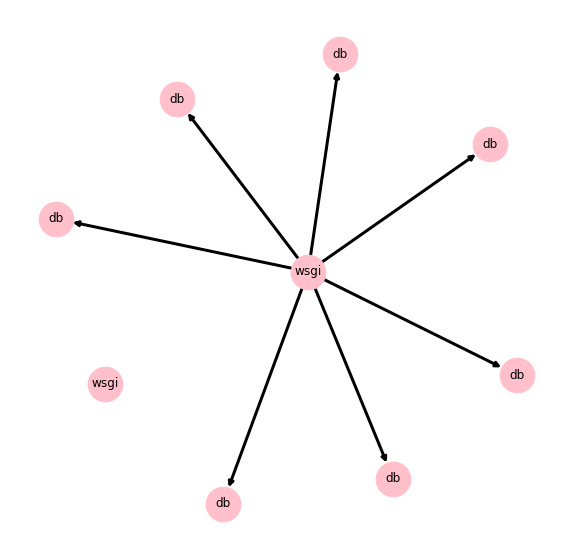

In [6]:
g = traces[operations[2]]['graph'][805]
plt.figure(figsize=(10, 10)) 
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos, nx.get_node_attributes(g, 'name'))
nx.draw(g, pos = pos, node_color = 'pink', node_size = 1200, font_size = 14, width = 3)
plt.show()

In [7]:
# create windowing
windowSize = 60
overlapping = 0
#overlapping = 0.25
n_s = int(windowSize * (1 - overlapping))
windows = []

timeStart = datetime.strptime('2019-11-19 17:38:38', '%Y-%m-%d %H:%M:%S')
timeEnd = datetime.strptime('2019-11-20 01:30:00', '%Y-%m-%d %H:%M:%S')

time = timeStart
while time + timedelta(seconds=windowSize) <= timeEnd:
    windows.append([time + timedelta(seconds=1), time + timedelta(seconds=windowSize)])
    time += timedelta(seconds=n_s)

ds = pd.DataFrame({'window': windows})

In [8]:
# create columns

def getLabel5(span):
    return span['host'] + '_' + span['operation'] + '_' + span['name'] + '_' + span['service'] + '_' + span['project']

def getLabel2(span):
    return span['host'] + '_' + span['name']

# aggregation graphs (2 and 5 features) columns
combinations = []
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            if span[1]['isRoot']:
                continue
            span_p = getLabel5(spans[list(trace.predecessors(span[0]))[0]])
            span_c = getLabel5(span[1])
            if span_c != span_p:
                communication = span_p + '->' + span_c
                if communication not in combinations:
                    combinations.append(communication)
                    ds[communication] = 0
                    ds[communication + '__duration'] = 0
                    
            span_p = getLabel2(spans[list(trace.predecessors(span[0]))[0]])
            span_c = getLabel2(span[1])
            if span_c != span_p:
                communication = span_p + '->' + span_c
                if communication not in combinations:
                    combinations.append(communication)
                    ds[communication] = 0
                    ds[communication + '__duration'] = 0
                    
# counting and duration (host_name) columns
combinations = []
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            combination = getLabel2(span[1])
            if combination not in combinations:
                combinations.append(combination)
                ds[combination] = 0
                ds[combination + '__duration'] = 0
                    
# communications between hosts (for plots)
for i in range(len(nodeNames)):
    for j in range(i + 1, len(nodeNames)):
        ds[nodeNames[i] + '_' + nodeNames[j] + '__total_number'] = 0
        ds[nodeNames[i] + '_' + nodeNames[j] + '__total_duration'] = 0

# total counting and duration per host columns (for plots)              
for host in nodeNames:
    ds[host + '__total_number'] = 0
    ds[host + '__total_duration'] = 0
    
# MI columns
for k in range(len(metrics)):
    for l in range(k, len(metrics)):
        for i in range(len(nodeNames)):
            t = (0, 1)[k == l]
            for j in range(i + t, len(nodeNames)):
                ds['MI' + '_' + nodeNames[i] + '_' + nodeNames[j] + '_' + metrics[k] + '_' + metrics[l]] = 0.0

In [9]:
# computing MI
f = 0
k = 0
while f < len(windows):
    for p in range(len(metrics)):
        for l in range(p, len(metrics)):
            for i in range(len(nodeNames)):
                t = (0, 1)[p == l]
                for j in range(i + t, len(nodeNames)):
                    mi = mutual_info_score(list(nodes[nodeNames[i]]['data'][metrics[p]])[k:k + windowSize],
                                           list(nodes[nodeNames[j]]['data'][metrics[l]])[k:k + windowSize])
                    ds.at[f, 'MI' + '_' + nodeNames[i] + '_' + nodeNames[j] + '_' + metrics[p] + '_' + metrics[
                        l]] = mi
    k += n_s
    f += 1

In [10]:
# collect data

# find index of window
def findIndex(time):
    for i in range(len(windows)):
        if (time <= windows[i][1]) and (time >= windows[i][0]):
            return i
    return -1

# get communication label with f function
def getCommunication(span, trace, f):
    if span[1]['isRoot']:
        return False, ''
    spans = trace.nodes(data = True)
    span_p = f(spans[list(trace.predecessors(span[0]))[0]])
    span_c = f(span[1])
    if span_c != span_p:
        communication = span_p + '->' + span_c
        return True, communication
    return False, ''

# get communication label between hosts
def getCommunicationHosts(span, trace):
    if span[1]['isRoot']:
        return False, ''
    spans = trace.nodes(data = True)
    span_p = spans[list(trace.predecessors(span[0]))[0]]['host']
    span_c = span[1]['host']
    if span_c != span_p:
        if nodeNames.index(span_p) < nodeNames.index(span_c):
            communication = span_p + '_' + span_c
            return True, communication
        communication = span_c + '_' + span_p
        return True, communication
    return False, ''

def increaseNumberAndDuration(row, column, duration, totalLabel):
    if totalLabel:
        ds.at[row, column + '__total_duration'] += duration
        ds.at[row, column + '__total_number'] += 1
    else:
        ds.at[row, column + '__duration'] += duration
        ds.at[row, column] += 1
    
def fillWindow(i_s, i_e, span, column, totalLabel = False):
    if (i_s == i_e):
        increaseNumberAndDuration(i_s, column, (span['endTimestamp'] - span['startTimestamp']).microseconds, totalLabel)
    else:
        if (i_e == -1):
            increaseNumberAndDuration(i_s, column, (windows[i_s][1] - span['startTimestamp']).microseconds, totalLabel)
        else:
            increaseNumberAndDuration(i_s, column, (windows[i_s][1] - span['startTimestamp']).microseconds, totalLabel)
            increaseNumberAndDuration(i_e, column, (windows[i_e][1] - span['endTimestamp']).microseconds, totalLabel)
            for i in range(1, i_e - i_s):
                increaseNumberAndDuration(i_s + i, column, (windows[i_s + 1][1] - windows[i_s + 1][0]).microseconds, totalLabel)
    
for operation in operations:
    for trace in traces[operation]['graph']:
        spans = trace.nodes(data = True)
        for span in spans:
            ts = span[1]['startTimestamp'].replace(microsecond = 0)
            i_s, i_e = findIndex(ts), -1
            if span[1]['endTimestamp'] != 'Null':
                te = span[1]['endTimestamp'].replace(microsecond = 0)
                i_e = findIndex(te)
            
            # graph with 5 features
            isCommunication, communication = getCommunication(span, trace, getLabel5)
            if isCommunication:
                fillWindow(i_s, i_e, span[1], communication)
            
            # graph with 2 features (host_name)    
            isCommunication, communication = getCommunication(span, trace, getLabel2)
            if isCommunication:
                fillWindow(i_s, i_e, span[1], communication)
            
            # counting and duration per host_name
            fillWindow(i_s, i_e, span[1], getLabel2(span[1]))
                
            # communications between hosts
            isCommunication, communication = getCommunicationHosts(span, trace)
            if isCommunication:
                fillWindow(i_s, i_e, span[1], communication, True)
            
            # total counting and duration per host
            fillWindow(i_s, i_e, span[1], span[1]['host'], True)

In [11]:
ds

,window,wally113_boot_delete_wsgi_public_keystone->wally113_boot_delete_db_public_keystone,wally113_boot_delete_wsgi_public_keystone->wally113_boot_delete_db_public_keystone__duration,wally113_wsgi->wally113_db,wally113_wsgi->wally113_db__duration,wally113_boot_delete_wsgi_osapi_compute_nova->wally113_boot_delete_wsgi_public_keystone,wally113_boot_delete_wsgi_osapi_compute_nova->wally113_boot_delete_wsgi_public_keystone__duration,wally113_boot_delete_wsgi_osapi_compute_nova->wally113_boot_delete_compute_api_osapi_compute_nova,wally113_boot_delete_wsgi_osapi_compute_nova->wally113_boot_delete_compute_api_osapi_compute_nova__duration,wally113_wsgi->wally113_compute_api,...,MI_wally113_wally117_mem.used_mem.used,MI_wally113_wally122_mem.used_mem.used,MI_wally113_wally123_mem.used_mem.used,MI_wally113_wally124_mem.used_mem.used,MI_wally117_wally122_mem.used_mem.used,MI_wally117_wally123_mem.used_mem.used,MI_wally117_wally124_mem.used_mem.used,MI_wally122_wally123_mem.used_mem.used,MI_wally122_wally124_mem.used_mem.used,MI_wally123_wally124_mem.used_mem.used
0,"[2019-11-19 17:38:39, 2019-11-19 17:39:38]",0,0,1477,4549499,0,0,0,0,0,...,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.071240,4.094345
1,"[2019-11-19 17:39:39, 2019-11-19 17:40:38]",0,0,1491,3571034,0,0,0,0,0,...,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.071240,4.094345,4.071240
2,"[2019-11-19 17:40:39, 2019-11-19 17:41:38]",0,0,1204,2293457,0,0,0,0,0,...,4.094345,4.094345,4.048135,4.094345,4.094345,4.048135,4.094345,4.048135,4.094345,4.048135
3,"[2019-11-19 17:41:39, 2019-11-19 17:42:38]",0,0,1254,2028888,0,0,0,0,0,...,4.048135,4.025030,4.048135,4.071240,4.025030,4.048135,4.071240,4.025030,4.048135,4.071240
4,"[2019-11-19 17:42:39, 2019-11-19 17:43:38]",0,0,1493,3175030,0,0,0,0,0,...,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345,4.094345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,"[2019-11-20 01:24:39, 2019-11-20 01:25:38]",0,0,0,0,0,0,0,0,0,...,4.071240,4.025030,4.071240,4.048135,4.048135,4.094345,4.071240,4.048135,4.025030,4.071240
467,"[2019-11-20 01:25:39, 2019-11-20 01:26:38]",0,0,0,0,0,0,0,0,0,...,3.970099,3.993204,3.970099,3.970099,4.071240,4.048135,4.048135,4.071240,4.071240,4.048135
468,"[2019-11-20 01:26:39, 2019-11-20 01:27:38]",0,0,0,0,0,0,0,0,0,...,4.048135,4.025030,4.025030,3.978820,4.071240,4.071240,4.025030,4.048135,4.001925,4.001925
469,"[2019-11-20 01:27:39, 2019-11-20 01:28:38]",0,0,0,0,0,0,0,0,0,...,4.094345,4.094345,4.094345,4.071240,4.094345,4.094345,4.071240,4.094345,4.071240,4.071240


In [12]:
# save data
title = 'non'
if overlapping != 0:
    title = str(int(overlapping * 100)) + '%'

ds.to_csv(pathToTraces / ('all_features_from_spans_' + title + '_overlapping.csv'), index=False)